In [30]:
# !python3 -m pip install matplotlib
# !python3 -m pip install seaborn
# !python3 -m pip install scikit-learn
# !python3 -m pip install openpyxl
# !python3 -m pip install pytz
# !python3 -m pip install plotly
!python3 -m pip install nbformat

In [16]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

In [20]:
# Load the transactional data
df = pd.read_excel('transactional_data.xlsx', parse_dates=['Date'])
df.head(10)

,InvoiceNo,Date,CustomerID,CustomerName,StockCode,Description,Quantity,UnitPrice,TotalAmount
0,44671292,2022-04-20,292,Shruti,NaN,Cheese Corn Bomb (Plate),1.0,140,140.0
1,44671292,2022-04-20,292,Shruti,NaN,Gool Poli (Plate),1.0,180,180.0
2,44671292,2022-04-20,292,Shruti,NaN,Puran Poli (Plate),1.0,180,180.0
3,44672118,2022-04-21,118,Mahapatra,NaN,Jowar Bhakri,2.0,42,84.0
4,44678192,2022-04-27,192,Pranesh,NaN,Chicken Thali,2.0,300,600.0
5,446823,2022-05-01,3,Aarti Patil,NaN,Tel Poli (1PC),20.0,50,1000.0
6,44682275,2022-05-01,275,Sharayu Nikam,NaN,Chicken Thali,1.0,300,300.0
7,44687293,2022-05-06,293,Shruti Padmakumar,NaN,Puran Poli Combo,1.0,165,165.0
8,44687293,2022-05-06,293,Shruti Padmakumar,NaN,Gool Poli (Plate),1.0,180,180.0
9,44687293,2022-05-06,293,Shruti Padmakumar,NaN,Matar Patties (Plate),1.0,220,220.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   InvoiceNo     805 non-null    int64         
 1   Date          805 non-null    datetime64[ns]
 2   CustomerID    805 non-null    int64         
 3   CustomerName  805 non-null    object        
 4   StockCode     0 non-null      float64       
 5   Description   805 non-null    object        
 6   Quantity      805 non-null    float64       
 7   UnitPrice     805 non-null    int64         
 8   TotalAmount   805 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 56.7+ KB


In [22]:
# Calculate Recency, Frequency and Monetary Value for each customer
rfm_table = df.groupby(['CustomerID']).agg({
    'Date': lambda x: (x.max() - x.min()).days,
    'InvoiceNo': pd.Series.nunique,
    'TotalAmount': 'sum'})
rfm_table.head(10)

,Date,InvoiceNo,TotalAmount
CustomerID,,,
1,0,1,350.0
2,81,3,12530.0
3,215,3,6725.0
4,0,1,204.0
5,1,2,231.0
6,0,1,65.0
7,0,1,82.0
8,0,1,180.0
9,0,1,84.0


In [23]:
# Rename the columns
rfm_table.rename(columns={'Date': 'Recency', 'InvoiceNo': 'Frequency', 'TotalAmount': 'MonetaryValue'}, inplace=True)
rfm_table.head(10)

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,0,1,350.0
2,81,3,12530.0
3,215,3,6725.0
4,0,1,204.0
5,1,2,231.0
6,0,1,65.0
7,0,1,82.0
8,0,1,180.0
9,0,1,84.0


In [24]:
# Perform normalization on RFM scores as the scores may have different scales and ranges that could bias the clustering results
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_table)
rfm_normalized = pd.DataFrame(rfm_scaled, columns=rfm_table.columns, index=rfm_table.index)
rfm_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,0.000000,0.0,0.026379
2,0.300000,0.4,1.000000
3,0.796296,0.4,0.535971
4,0.000000,0.0,0.014708
5,0.003704,0.2,0.016867


In [25]:
rfm_normalized['Recency'] = 1 - rfm_normalized['Recency']
rfm_normalized.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
1,1.000000,0.0,0.026379
2,0.700000,0.4,1.000000
3,0.203704,0.4,0.535971
4,1.000000,0.0,0.014708
5,0.996296,0.2,0.016867


In [26]:
# Perform hierarchical clustering using AgglomerativeClustering with user defined number of clusters
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(rfm_scaled)

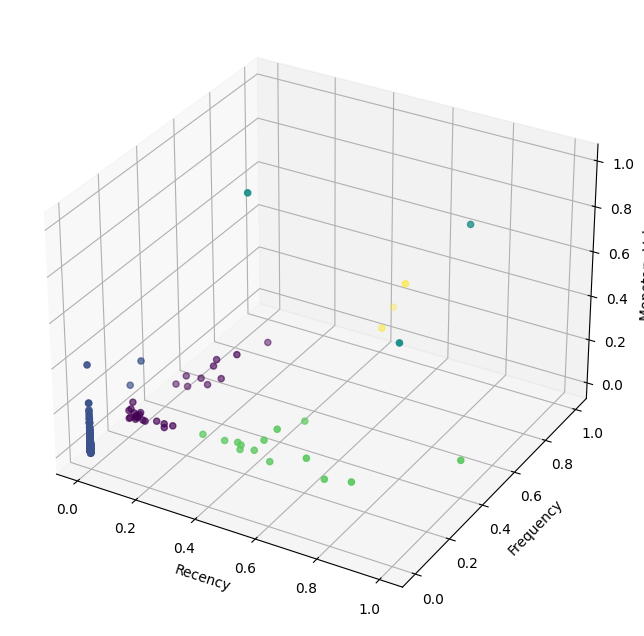

In [27]:
# Visualize the clusters on a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
x = rfm_scaled[:, 0]
y = rfm_scaled[:, 1]
z = rfm_scaled[:, 2]
ax.scatter(x, y, z, c=clustering.labels_)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary Value')
plt.show()